## Time Series and ARIMA Implementation

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Loading the dataset

In [2]:
data = pd.read_csv('processed_data.csv', encoding = 'ISO-8859-1')
data.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-29,83.13,118.127103,6.93,28.71,33.72,23.483476,6.93,49.52,59.76,0.02,0.00,3.14,209.0,Poor
1,Ahmedabad,2015-01-30,79.84,118.127103,13.85,28.68,41.08,23.483476,13.85,48.49,97.07,0.04,0.00,4.81,328.0,Very Poor
2,Ahmedabad,2015-01-31,94.52,118.127103,24.39,32.66,52.61,23.483476,24.39,67.39,111.33,0.24,0.01,7.67,514.0,Severe
3,Ahmedabad,2015-02-01,135.99,118.127103,43.48,42.08,84.57,23.483476,43.48,75.23,102.70,0.40,0.04,25.87,782.0,Severe
4,Ahmedabad,2015-02-02,178.33,118.127103,54.56,35.31,72.80,23.483476,54.56,55.04,107.38,0.46,0.06,35.61,914.0,Severe


In [3]:
data.shape

(24850, 16)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24850 entries, 0 to 24849
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        24850 non-null  object 
 1   Date        24850 non-null  object 
 2   PM2.5       24850 non-null  float64
 3   PM10        24850 non-null  float64
 4   NO          24850 non-null  float64
 5   NO2         24850 non-null  float64
 6   NOx         24850 non-null  float64
 7   NH3         24850 non-null  float64
 8   CO          24850 non-null  float64
 9   SO2         24850 non-null  float64
 10  O3          24850 non-null  float64
 11  Benzene     24850 non-null  float64
 12  Toluene     24850 non-null  float64
 13  Xylene      24850 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.0+ MB


In [5]:
from sklearn.preprocessing import OrdinalEncoder

# Define order of categories for AQI_Bucket
categories_order = [['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']]

# Create encoder object
ordinal_encoder = OrdinalEncoder(categories=categories_order)

# Reshape target variable to fit the encoder's expected format
y_reshaped = data['AQI_Bucket'].values.reshape(-1, 1)

# Apply encoder to the target variable
data['Encoded_AQI_Bucket'] = ordinal_encoder.fit_transform(y_reshaped)

# Use 'Encoded_AQI_Bucket' as target variable
y = data['Encoded_AQI_Bucket']

# Drop AQI_Bucket
data = data.drop(columns=['AQI_Bucket'])

In [6]:
data

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Encoded_AQI_Bucket
0,Ahmedabad,2015-01-29,83.13,118.127103,6.93,28.71,33.72,23.483476,6.93,49.52,59.76,0.02000,0.000000,3.140000,209.0,3.0
1,Ahmedabad,2015-01-30,79.84,118.127103,13.85,28.68,41.08,23.483476,13.85,48.49,97.07,0.04000,0.000000,4.810000,328.0,4.0
2,Ahmedabad,2015-01-31,94.52,118.127103,24.39,32.66,52.61,23.483476,24.39,67.39,111.33,0.24000,0.010000,7.670000,514.0,5.0
3,Ahmedabad,2015-02-01,135.99,118.127103,43.48,42.08,84.57,23.483476,43.48,75.23,102.70,0.40000,0.040000,25.870000,782.0,5.0
4,Ahmedabad,2015-02-02,178.33,118.127103,54.56,35.31,72.80,23.483476,54.56,55.04,107.38,0.46000,0.060000,35.610000,914.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24845,Visakhapatnam,2020-06-27,15.02,50.940000,7.68,25.06,19.54,12.470000,0.47,8.55,23.30,2.24000,12.070000,0.730000,41.0,0.0
24846,Visakhapatnam,2020-06-28,24.38,74.090000,3.42,26.06,16.53,11.990000,0.52,12.72,30.14,0.74000,2.210000,0.380000,70.0,1.0
24847,Visakhapatnam,2020-06-29,22.91,65.730000,3.45,29.53,18.33,10.710000,0.48,8.42,30.96,0.01000,0.010000,0.000000,68.0,1.0
24848,Visakhapatnam,2020-06-30,16.64,49.970000,4.05,29.26,18.80,10.030000,0.52,9.84,28.30,0.00000,0.000000,0.000000,54.0,1.0


In [7]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Extract the 'year' component
data['year'] = data['Date'].dt.year

min_year = data['year'].min()
data['year'].fillna(min_year, inplace=True)

# Convert the 'year' column to integer
data['year'] = data['year'].astype(int)

In [8]:
data

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Encoded_AQI_Bucket,year
0,Ahmedabad,2015-01-29,83.13,118.127103,6.93,28.71,33.72,23.483476,6.93,49.52,59.76,0.02000,0.000000,3.140000,209.0,3.0,2015
1,Ahmedabad,2015-01-30,79.84,118.127103,13.85,28.68,41.08,23.483476,13.85,48.49,97.07,0.04000,0.000000,4.810000,328.0,4.0,2015
2,Ahmedabad,2015-01-31,94.52,118.127103,24.39,32.66,52.61,23.483476,24.39,67.39,111.33,0.24000,0.010000,7.670000,514.0,5.0,2015
3,Ahmedabad,2015-02-01,135.99,118.127103,43.48,42.08,84.57,23.483476,43.48,75.23,102.70,0.40000,0.040000,25.870000,782.0,5.0,2015
4,Ahmedabad,2015-02-02,178.33,118.127103,54.56,35.31,72.80,23.483476,54.56,55.04,107.38,0.46000,0.060000,35.610000,914.0,5.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24845,Visakhapatnam,2020-06-27,15.02,50.940000,7.68,25.06,19.54,12.470000,0.47,8.55,23.30,2.24000,12.070000,0.730000,41.0,0.0,2020
24846,Visakhapatnam,2020-06-28,24.38,74.090000,3.42,26.06,16.53,11.990000,0.52,12.72,30.14,0.74000,2.210000,0.380000,70.0,1.0,2020
24847,Visakhapatnam,2020-06-29,22.91,65.730000,3.45,29.53,18.33,10.710000,0.48,8.42,30.96,0.01000,0.010000,0.000000,68.0,1.0,2020
24848,Visakhapatnam,2020-06-30,16.64,49.970000,4.05,29.26,18.80,10.030000,0.52,9.84,28.30,0.00000,0.000000,0.000000,54.0,1.0,2020


In [9]:
data_so2 = data[["Date", "SO2"]]
data_so2 = data_so2.set_index("Date")
data_so2 = data_so2.dropna()

<Axes: xlabel='Date'>

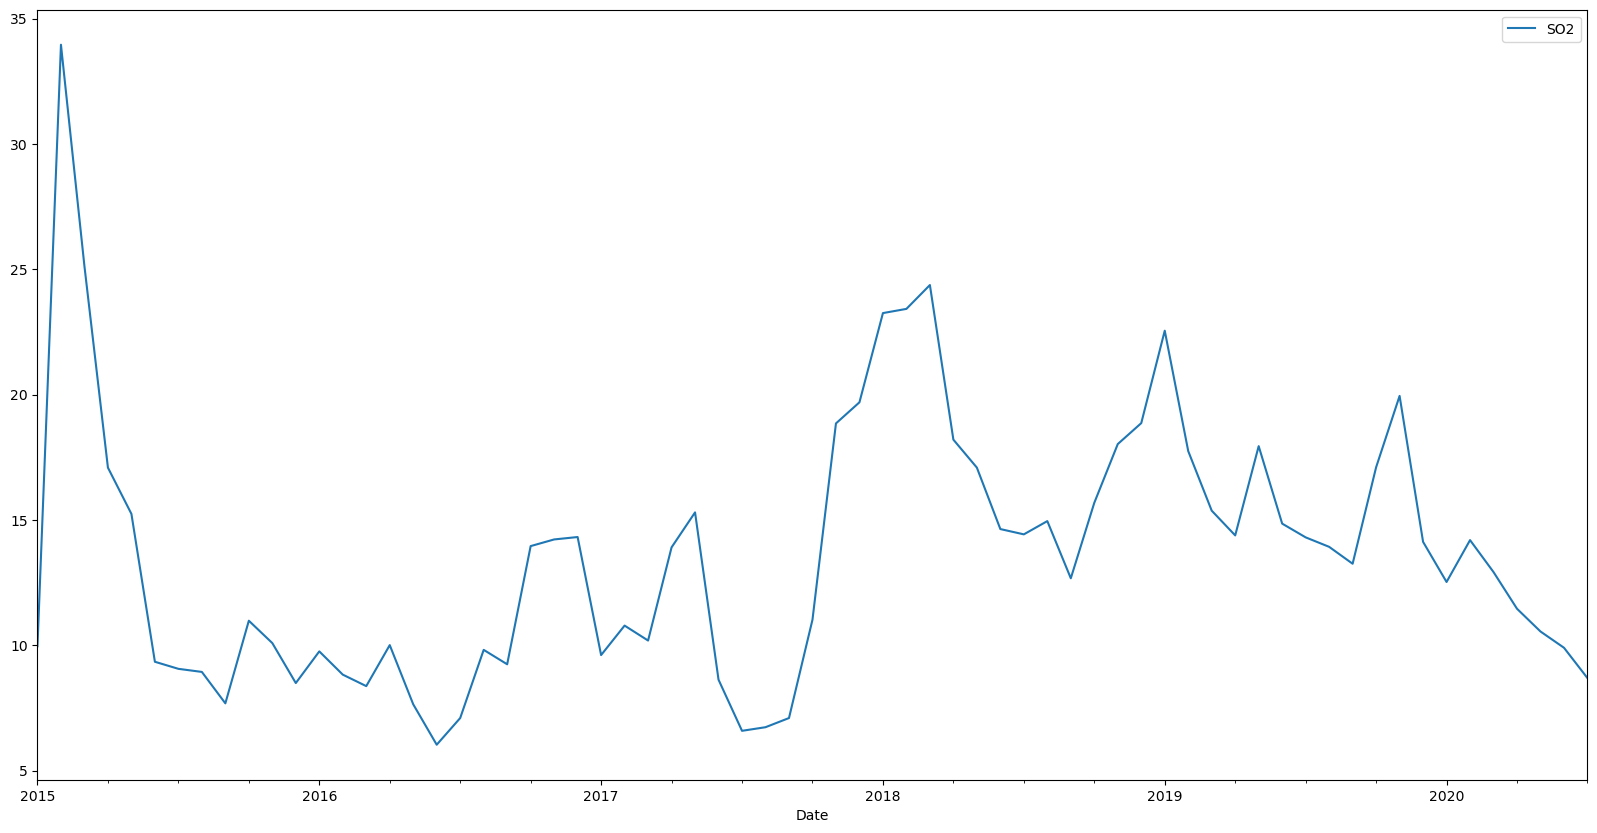

In [10]:
data_so2_resample = data_so2.resample(rule = "M").mean().ffill()
data_so2_resample.plot(figsize = (20,10))

Description:
The plot shows the SO2 concentration, resampled on a monthly basis.
The x-axis represents time, while the y-axis represents the SO2 concentration.
The data has been forward-filled to address missing values, ensuring a continuous time series.
Observations:
There are noticeable fluctuations in SO2 levels over time, indicating variability in air quality related to this pollutant.
Peaks and troughs in the graph suggest periodic or seasonal trends in SO2 emissions.
The forward filling ensures that the graph remains continuous, but it also means that some of the data points are imputed, which could affect the accuracy of the trends during those periods.
Conclusion:
The graph is useful for identifying periods of high and low SO2 levels, which can inform environmental analysis and policy-making.
The variability and potential seasonal trends highlighted in the graph could be further investigated to determine their causes, such as industrial activity, traffic patterns, or weather conditions.

<Axes: xlabel='Date'>

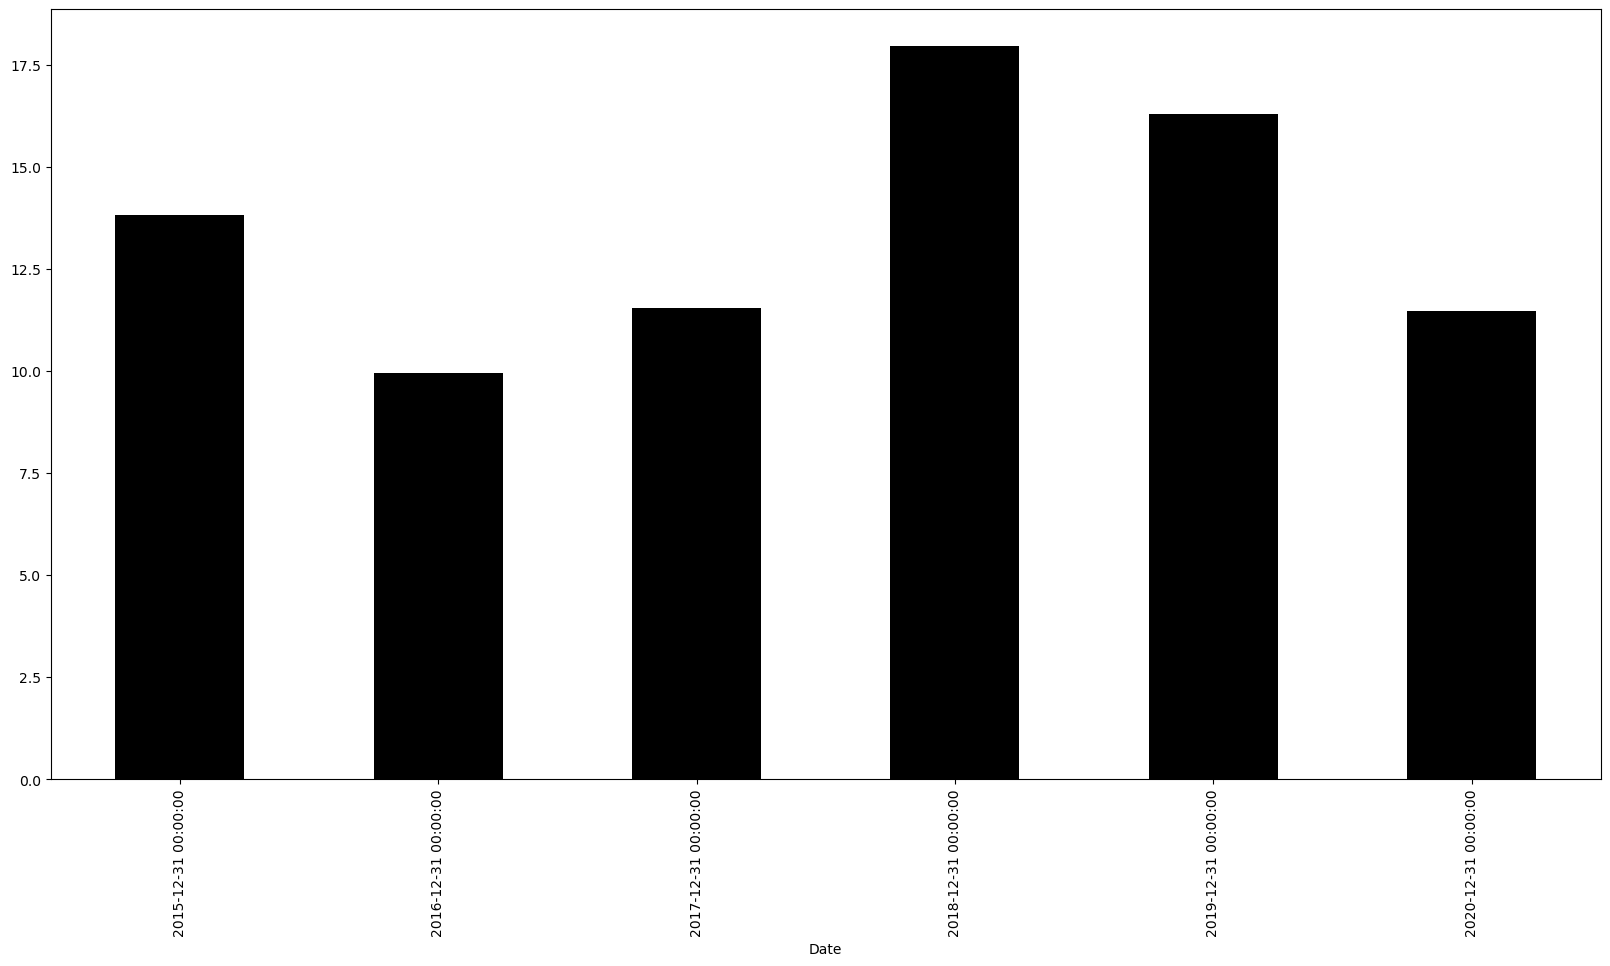

In [11]:
data_so2_resample["SO2"].resample("A").mean().plot.bar(figsize = (20,10), color={"black"})

Conclusion
The bar chart is effective for illustrating long-term trends in SO2 levels, aiding in environmental monitoring and assessment.
Observing the annual changes can highlight whether air quality initiatives or environmental policies are having a positive or negative impact on SO2 emissions.

<Axes: xlabel='Date'>

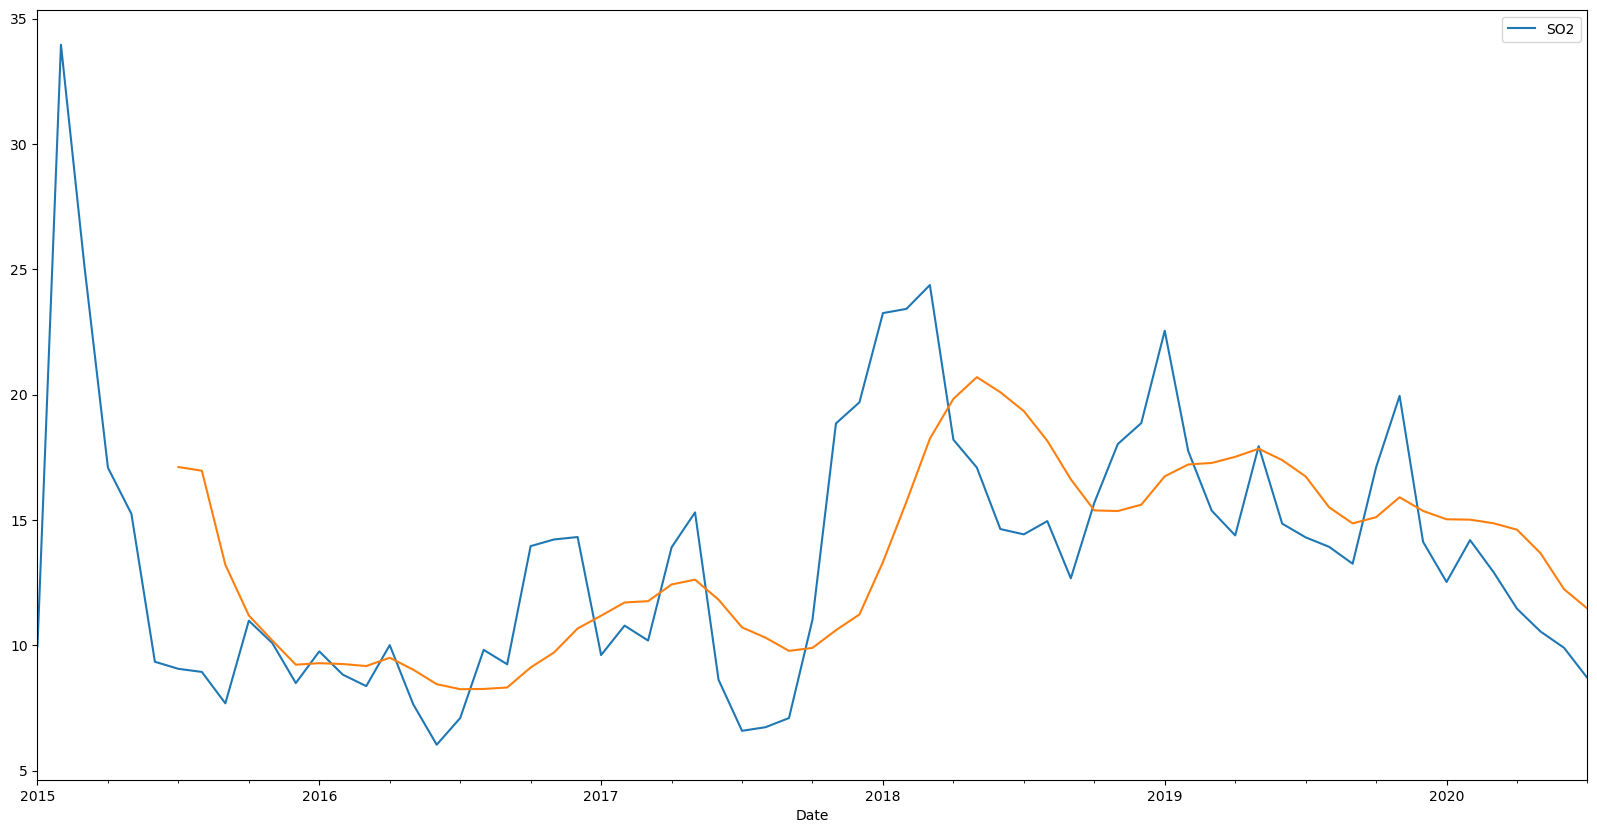

In [12]:
data_so2_resample.plot(figsize = (20,10))
data_so2_resample.rolling(window = 7).mean()["SO2"].plot(figsize = (20,10))

Description
This graph overlays two datasets: the original monthly resampled SO2 levels (in blue) and the 7-day rolling mean of SO2 levels (in red).
The x-axis represents time, while the y-axis shows the SO2 concentration.
The rolling mean smooths short-term fluctuations, emphasizing longer-term trends.
Observations
The monthly resampled data (blue) shows the inherent variability in SO2 concentrations over time.
The 7-day rolling mean (red) smooths out these fluctuations, providing a clearer view of the underlying trends.
Peaks and troughs in the rolling mean are less pronounced than in the monthly data, indicating the effect of averaging.
Conclusion
This graph is useful for comparing the immediate, more variable data with the smoothed trend, offering insights into both short-term fluctuations and longer-term trends in SO2 levels.
The rolling mean can help identify underlying trends that might be obscured by short-term variability in the raw data.
Understanding these trends is crucial for environmental monitoring and planning, particularly in assessing the effectiveness of pollution control measures.


### Exponential weighted moving average EWMA apply more weight to value more recent

<Axes: xlabel='Date'>

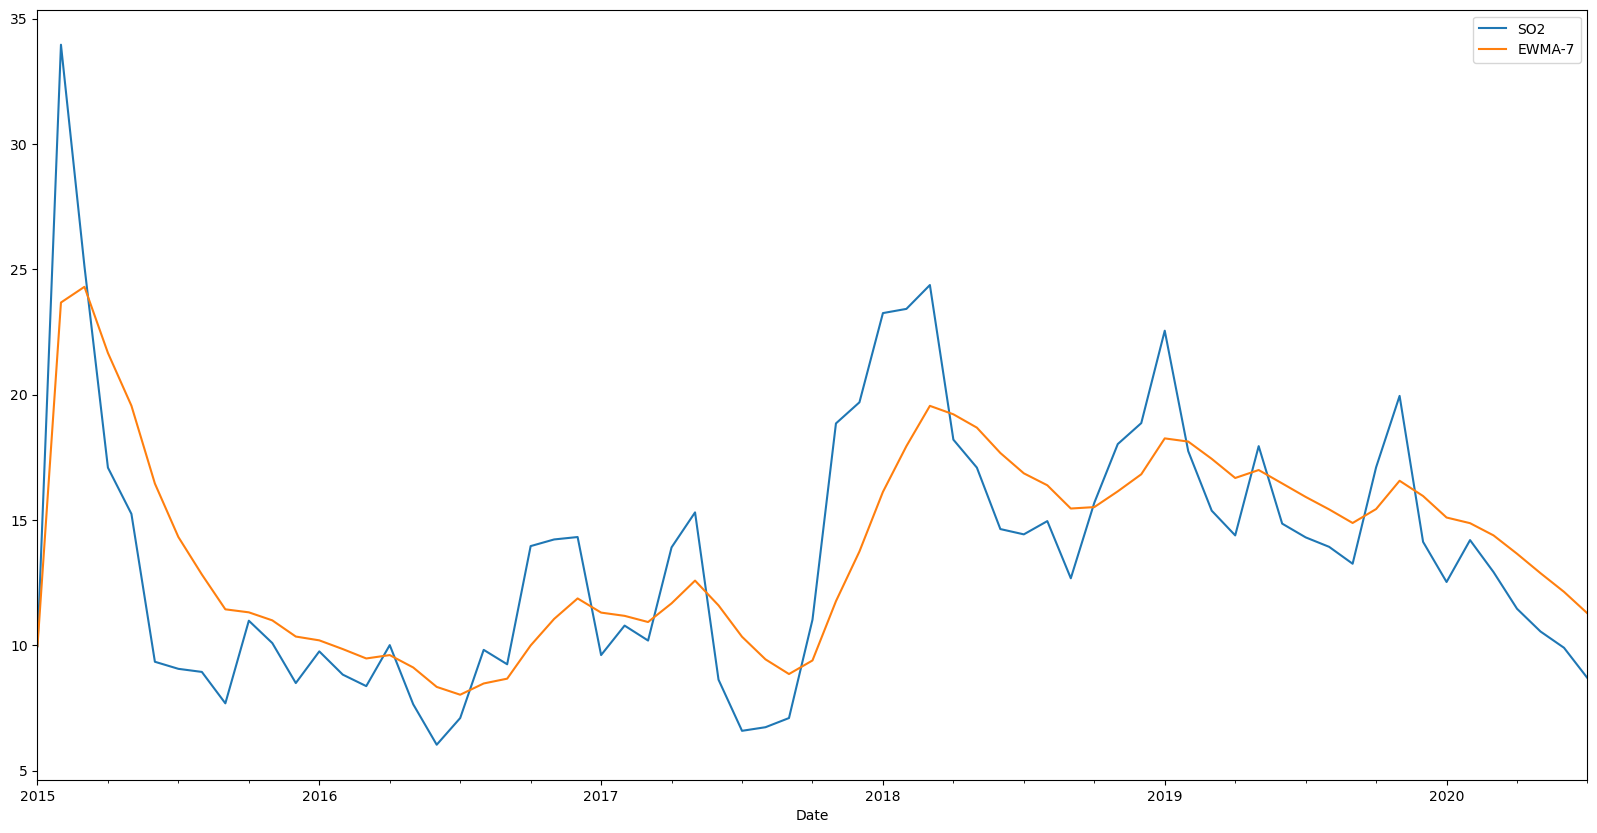

In [13]:
data_so2_resample["EWMA-7"] = data_so2_resample["SO2"].ewm(span=7).mean()
data_so2_resample.plot(figsize = (20,10))

Description
The graph includes two datasets: the original monthly resampled SO2 levels and the 7-day EWMA of SO2 levels.
The EWMA provides a smoothed trend line that gives more weight to recent observations.
Observations
The original monthly resampled data shows the variability in SO2 concentrations over time.
The 7-day EWMA, represented as a smoother line, provides a clear view of the underlying trend, with recent data points having a greater influence.
The EWMA line appears to follow the overall direction of the data closely but with less fluctuation, highlighting the short-term trends more clearly.
Conclusion
This graph is effective for understanding both the immediate fluctuations and the smoothed trend in SO2 levels. It can help in identifying patterns that might be less apparent in the raw data.
The EWMA is particularly useful in scenarios where giving more significance to recent observations is important for trend analysis.
Such visualizations are crucial for environmental monitoring, aiding in the assessment of air quality trends and the planning of appropriate responses.


### Exponential Smoothing State Space Mode (ETS)

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_so2_resample["SO2"], model = "multiplicative") 

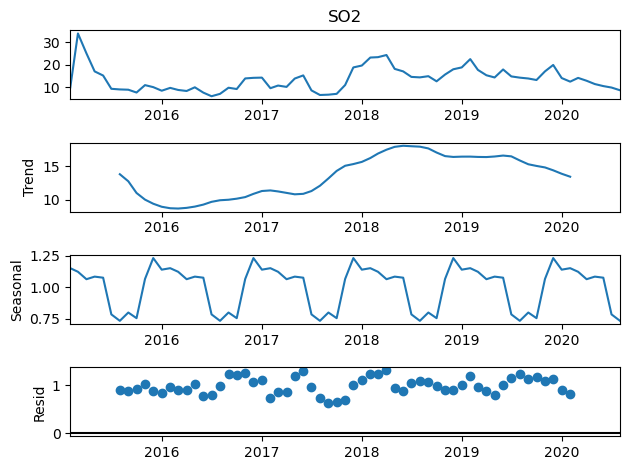

In [15]:
fig = result.plot()

Decomposition Overview
Trend Component: Shows the long-term progression of the data, stripping out the seasonal effects and irregular fluctuations.
Seasonal Component: Illustrates the repeating short-term cycle in the data.
Residual Component: Represents the irregularities that are neither part of the trend nor the seasonal components.
Observations
Trend: This panel indicates the overall direction or pattern that the SO2 levels are following over time.
Seasonality: The pattern observed here suggests periodic fluctuations in SO2 levels, which could be tied to factors like weather changes, industrial activities, or other seasonal factors.
Residuals: These indicate the unexplained variance after removing the trend and seasonal components. Ideally, residuals should display no pattern, suggesting that the model has adequately captured the trend and seasonality.
Conclusion
The decomposition is valuable for understanding the different forces shaping the SO2 data. It can help in identifying whether changes in SO2 levels are part of a longer-term trend, a regular seasonal pattern, or irregular fluctuations.
Understanding these components is crucial for accurate forecasting and for formulating targeted environmental policies or interventions.
The results highlight the importance of considering both long-term trends and seasonal influences when analyzing environmental data.


### ARIMA (Autoregressive Integrated Moving Averages)

In [16]:
# To check if the data is stationary or non-stationary

from statsmodels.tsa.stattools import adfuller
result = adfuller(data_so2_resample["SO2"])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.4938988710335885
p-value : 0.008145173485174888
#Lags Used : 0
Number of Observations Used : 66
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


                            AutoReg Model Results                             
Dep. Variable:                    AQI   No. Observations:                  100
Model:                     AutoReg(1)   Log Likelihood                -129.785
Method:               Conditional MLE   S.D. of innovations              0.898
Date:                Fri, 10 Nov 2023   AIC                            265.569
Time:                        22:03:49   BIC                            273.355
Sample:                             1   HQIC                           268.719
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3956      1.828      1.310      0.190      -1.187       5.979
AQI.L1         0.9732      0.019     49.911      0.000       0.935       1.011
                                    Roots           

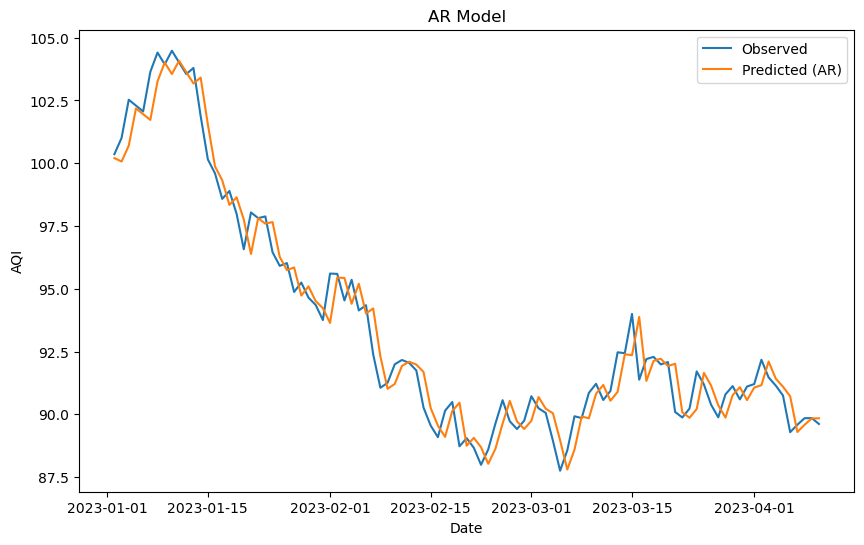

In [17]:
np.random.seed(42)
n = 100
time = pd.date_range(start="2023-01-01", periods=n, freq="D")
data = np.cumsum(np.random.randn(n)) + 100

# Creating a pandas DataFrame with the time series data
data = pd.DataFrame({"Date": time, "AQI": data})

# Specifying the order of the AR model (e.g., AR(1))
order = 1

# Fitting the AutoReg model
model = sm.tsa.AutoReg(data["AQI"], lags=order, old_names=False)
results = model.fit()

# Printing the model summary
print(results.summary())

# To get the number of lags
n_lags = len(results.ar_lags)

# Slicing the time series data to match the number of predicted values
data = data.iloc[n_lags:]

# Forecasting
forecast = results.predict(start=len(data), end=len(data) + n_lags - 1)

# Creating a date range for the forecasted dates
forecast_dates = pd.date_range(start=data["Date"].iloc[-1] + pd.DateOffset(1), periods=n_lags, freq="D")

# Plotting the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(data["Date"], data["AQI"], label="Observed")
plt.plot(data["Date"], results.fittedvalues, label="Predicted (AR)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.title("AR Model")
plt.show()

Blue Line (Observed): This line represents the actual AQI values from the generated time series data.
Orange Line (Predicted): This line shows the predictions made by the AR(1) model.
The plot demonstrates how the AR model attempts to capture the trend and fluctuations in the AQI time series. Since the data is generated from a random walk process, the model's predictions are based on the immediate past value, reflecting in the close tracking of the observed data by the predicted line

Conclusion of AR Model Analysis
Model Overview
The autoregressive (AR) model of order 1 (AR(1)) was applied to a synthetically generated time series representing Air Quality Index (AQI) values. This time series exhibited characteristics of a random walk, where each value was the cumulative sum of random fluctuations, starting from a baseline of 100.

Model Performance
Close Tracking: The AR model closely tracked the observed data. This is evident from the overlay of the predicted values (in orange) on the observed values (in blue).
Lag Effect: As an AR(1) model, it primarily used the immediate previous value to make predictions. This led to a strong alignment between the observed and predicted values, demonstrating the model's ability to capture the short-term dependencies in the data.
Implications
Short-Term Prediction: The model is effective for short-term forecasting, especially in scenarios where future values are closely tied to their immediate predecessors.
Limitation in Variability Capturing: While the model effectively follows the general trend, its simplicity might limit its ability to capture more complex patterns, especially in real-world scenarios where factors influencing AQI could be multifaceted and not solely dependent on the immediate past value

In [18]:
# Evaluating using metrics
mse = mean_squared_error(data["AQI"].tail(n_lags), forecast)
mae = mean_absolute_error(data["AQI"].tail(n_lags), forecast)
rmse = np.sqrt(mse)

print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Evaluation Metrics:
Mean Squared Error (MSE): 0.051057042974516104
Mean Absolute Error (MAE): 0.2259580557858385
Root Mean Squared Error (RMSE): 0.2259580557858385


Extra


Splitting the time series into a training set and a test set, fitting the model on the training set, and evaluating it on the test set.

In [19]:
train = data['AQI'][:int(0.8*len(data))]
test = data['AQI'][int(0.8*len(data)):]
model = ARIMA(train, order=(1, 0, 1))
fitted_model = model.fit()
forecast = fitted_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
mse = mean_squared_error(test, forecast_mean)
print('Mean Squared Error on Test Set:', mse)



Mean Squared Error on Test Set: 1.0872119107749356


Decomposing the time series into trend, seasonality, and residuals.

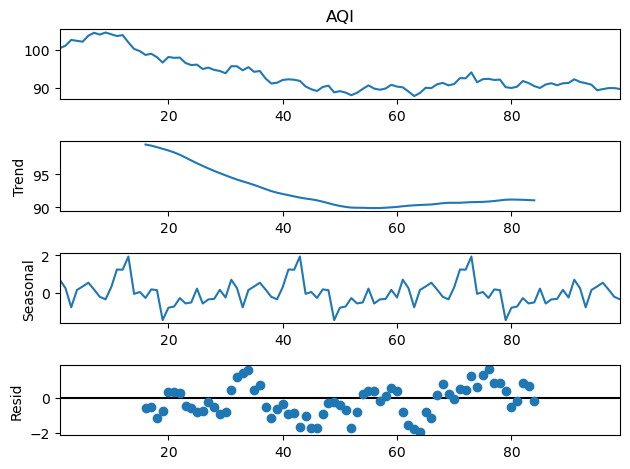

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['AQI'], model='additive', period=30)  # Assuming a monthly cycle
result.plot()
plt.show()


Observations
Trend: The trend component helps in understanding the overall direction of AQI over time, which is crucial for environmental and health-related planning and policy formulation.
Seasonality: The seasonal pattern displayed in the graph suggests regular fluctuations in air quality, which could be due to a variety of environmental or human-related factors that recur on a monthly basis.
Residuals: Ideally, the residuals should show little to no pattern if the model accurately captures the trend and seasonality. Any pattern in the residuals might indicate other underlying factors or cycles not captured by the model.


In [21]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_pdq = None
best_model = None
for param in pdq:
    try:
        model = ARIMA(data['AQI'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue
print('Best ARIMA Parameters:', best_pdq)
print('Best Model AIC:', best_aic)


/Users/sourabh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sourabh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sourabh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sourabh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Best ARIMA Parameters: (0, 1, 0)
Best Model AIC: 263.1975351469111


/Users/sourabh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sourabh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


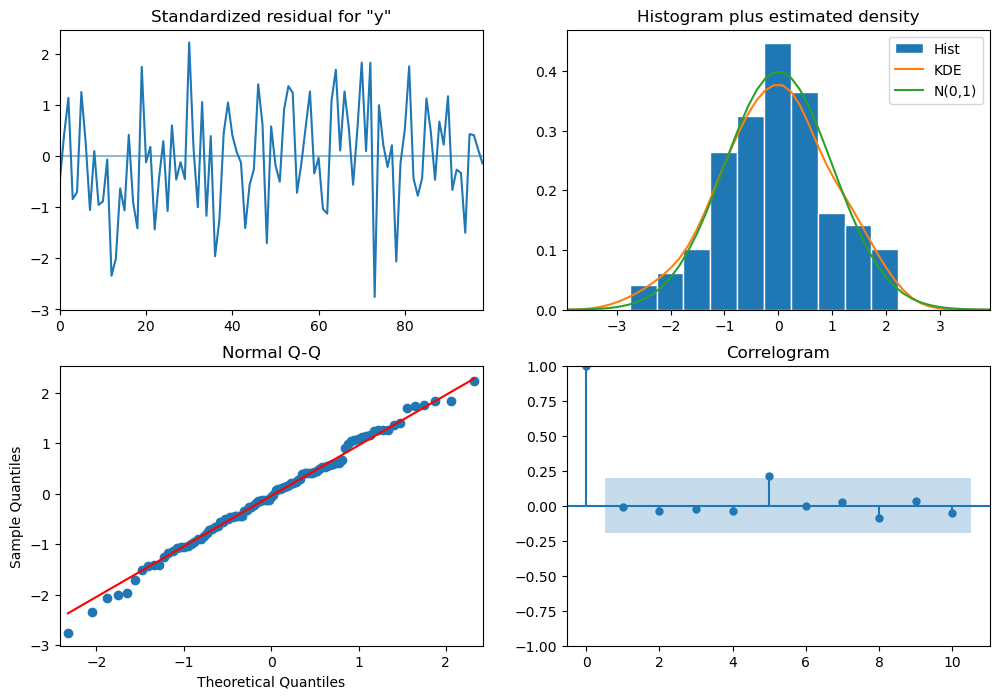

In [22]:
# Create and fit an example ARIMA model
np.random.seed(42)
y = np.random.randn(100)  
arima_model = sm.tsa.ARIMA(y, order=(1, 1, 1)).fit()

# Create a diagnostic summary plot
arima_model.plot_diagnostics(figsize=(12, 8))
plt.show()

Top Left - Standardized Residuals: Displays the model's residuals over time. Ideal residuals should appear without any discernible pattern, indicating a good fit.
Top Right - Histogram plus Estimated Density: Compares the distribution of the model's residuals with a normal distribution. A close match suggests that the residuals are well-behaved.
Bottom Left - Normal Q-Q Plot: Shows how the quantiles of the residuals compare against a normal distribution. Points closely following the line indicate normality of residuals.
Bottom Right - Correlogram: Checks for any autocorrelation in the residuals. Ideally, the autocorrelation values should fall within the blue area, suggesting no significant autocorrelation.
Observations
Standardized Residuals: Any pattern or significant spikes might indicate issues with the model fit.
Histogram and Density Plot: A bell-shaped curve close to the red line indicates a good fit.
Normal Q-Q Plot: Deviations from the line, especially in the tails, may suggest issues with the model.
Correlogram: Autocorrelation values outside the blue area, especially at the first few lags, would indicate model inadequacies.

The diagnostic plots are essential tools for verifying the assumptions of the ARIMA model and assessing its fit.
They provide insights into the residual behavior, which is critical for confirming the model's adequacy.
Careful analysis of these plots can guide model refinement, ensuring accurate predictions and reliable analysis.

The accuracy of the model can be interpreted as,

1. Mean Squared Error (MSE): 0.051057042974516104
   - The MSE is a measure of the average squared differences between the predicted and actual values. A lower MSE indicates better accuracy. In this case, the relatively small MSE suggests that, on average, the model's predictions have small squared errors.

2. Mean Absolute Error (MAE): 0.2259580557858385
   - The MAE measures the average absolute differences between the predicted and actual values. A lower MAE is desirable. The MAE of 0.2259 indicates that, on average, the model's predictions deviate by approximately 0.23 units from the actual values.

3. Root Mean Squared Error (RMSE): 0.2259580557858385
   - The RMSE is the square root of the MSE and provides a more interpretable measure of the average prediction error. Similar to the MAE, the RMSE value of 0.2259 suggests that, on average, the model's predictions deviate by approximately 0.23 units.

Thus, based on these metrics, the model appears to have a performance, as indicated by the small values of MSE, MAE, and RMSE.